In [33]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

os.chdir('/home/dannya1/lanesegnet')

print(f"Working directory: {os.getcwd()}")

Working directory: /home/dannya1/lanesegnet


In [34]:
# Import mmcv and mmdet
from mmcv import Config
from mmdet.datasets import build_dataset
from torch.utils.data import DataLoader

# Import custom modules
import projects.bevformer
import projects.lanesegnet

## Load Configuration and Build Dataset

In [35]:
# Load config
config_file = 'projects/configs/lanesegnet_r50_8x1_24e_olv2_subset_A.py'
cfg = Config.fromfile(config_file)

print(f"Dataset type: {cfg.data.train.type}")
print(f"Data root: {cfg.data.train.data_root}")
print(f"Annotation file: {cfg.data.train.ann_file}")
print(f"Number of points per polyline: {cfg.data.train.points_num}")

Dataset type: OpenLaneV2_subset_A_LaneSegNet_Dataset
Data root: data/OpenLane-V2/
Annotation file: data/OpenLane-V2/data_dict_subset_A_train_lanesegnet.pkl
Number of points per polyline: 10


In [36]:
# Build the training dataset with all pipelines
train_dataset = build_dataset(cfg.data.train)

print(f"\nDataset built successfully!")
print(f"Total samples: {len(train_dataset)}")
print(f"\nPipeline transforms:")
for i, transform in enumerate(train_dataset.pipeline.transforms):
    print(f"  {i+1}. {transform.__class__.__name__}")


Dataset built successfully!
Total samples: 22349

Pipeline transforms:
  1. CustomLoadMultiViewImageFromFiles
  2. LoadAnnotations3DLaneSegment
  3. PhotoMetricDistortionMultiViewImage
  4. CropFrontViewImageForAv2
  5. RandomScaleImageMultiViewImage
  6. NormalizeMultiviewImage
  7. PadMultiViewImageSame2Max
  8. GridMaskMultiViewImage
  9. LaneSegmentParameterize3D
  10. GenerateLaneSegmentMask
  11. CustomFormatBundle3DLane
  12. CustomCollect3D


## Create DataLoader (Same as Training)

In [37]:
# Create dataloader with same settings as training
from mmdet.datasets import build_dataloader

train_dataloader = build_dataloader(
    train_dataset,
    samples_per_gpu=cfg.data.samples_per_gpu,
    workers_per_gpu=0,  # Set to 0 for notebook to avoid multiprocessing issues
    dist=False,
    shuffle=True,
    seed=None
)

print(f"DataLoader created with batch size: {cfg.data.samples_per_gpu}")
print(f"Total batches: {len(train_dataloader)}")

DataLoader created with batch size: 1
Total batches: 22349


## Explore Ground Truth Data

In [38]:
# Collect polylines from the dataset
polylines = []
labels = []
num_batches_to_sample = 1  # Adjust this to sample more or fewer batches

print(f"Collecting polylines from {num_batches_to_sample} batches...")

for batch_idx, data_batch in enumerate(train_dataloader):
    if batch_idx >= num_batches_to_sample:
        break
    
    # Get ground truth lanes (key: 'gt_lanes_3d')
    gt_lanes_batch = data_batch['gt_lanes_3d'].data[0]  # data[0] to get the actual tensor list
    gt_labels_batch = data_batch['gt_lane_labels_3d'].data[0]
    
    # Process each sample in the batch
    for sample_idx, (gt_lanes, gt_lane_labels) in enumerate(zip(gt_lanes_batch, gt_labels_batch)):
        # Process each polyline in the sample
        for polyline_idx, (polyline, label) in enumerate(zip(gt_lanes, gt_lane_labels)):
            # Reshape polyline to (n_points, 3) and convert to CPU
            polyline_reshaped = polyline.view(-1, 3).detach().cpu()
            polylines.append(polyline_reshaped)
            labels.append(label.item())
    
    if (batch_idx + 1) % 5 == 0:
        print(f"  Processed {batch_idx + 1} batches, collected {len(labels)} polylines so far")

print(f"\nTotal polylines collected: {len(polylines)}")
print(f"Polyline shape: {polylines[0].shape if polylines else 'N/A'}")


Total polylines collected: 51
Polyline shape: torch.Size([30, 3])

Total polylines collected: 51
Polyline shape: torch.Size([30, 3])


In [39]:
# Count polylines by label
from collections import Counter

label_counts = Counter(labels)
print(f"\nPolyline distribution by label:")
for label, count in sorted(label_counts.items()):
    label_name = cfg.data.train.classes[label] if label < len(cfg.data.train.classes) else f"class_{label}"
    print(f"  {label_name} (label {label}): {count} polylines")


Polyline distribution by label:
  lane_segment (label 0): 49 polylines
  ped_crossing (label 1): 2 polylines


## Visualize Polylines

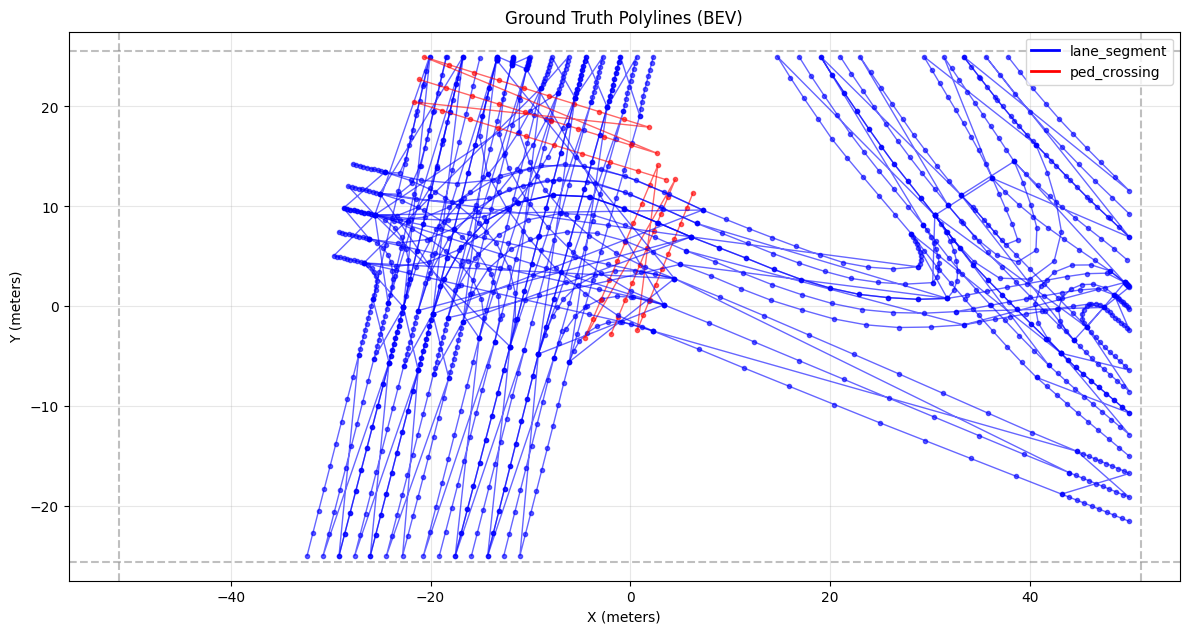

In [40]:
# Visualize a sample of polylines in BEV (Bird's Eye View)
def plot_polylines_bev(polylines, labels, num_samples=50, title="Ground Truth Polylines (BEV)"):
    """
    Plot polylines in bird's eye view (top-down view)
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Sample polylines to plot
    indices = np.random.choice(len(polylines), min(num_samples, len(polylines)), replace=False)
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for idx in indices:
        polyline = polylines[idx].numpy()
        label = labels[idx]
        color = colors[label % len(colors)]
        
        # Plot X-Y coordinates (BEV)
        ax.plot(polyline[:, 0], polyline[:, 1], 'o-', color=color, alpha=0.6, markersize=3, linewidth=1)
    
    # Create legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color=colors[i], lw=2, label=cfg.data.train.classes[i]) 
                      for i in range(len(cfg.data.train.classes))]
    ax.legend(handles=legend_elements, loc='upper right')
    
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    # Add point cloud range reference
    pc_range = cfg.point_cloud_range
    ax.axhline(y=pc_range[1], color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=pc_range[4], color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=pc_range[0], color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=pc_range[3], color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Plot sample polylines
plot_polylines_bev(polylines, labels, num_samples=100)

In [ ]:
# Analyze polyline statistics
print("\nPolyline Statistics:")
print("=" * 50)

# Convert to numpy for easier analysis
polylines_np = [p.numpy() for p in polylines]

# X coordinate range
x_coords = np.concatenate([p[:, 0] for p in polylines_np])
print(f"X coordinates: min={x_coords.min():.2f}, max={x_coords.max():.2f}, mean={x_coords.mean():.2f}")

# Y coordinate range
y_coords = np.concatenate([p[:, 1] for p in polylines_np])
print(f"Y coordinates: min={y_coords.min():.2f}, max={y_coords.max():.2f}, mean={y_coords.mean():.2f}")

# Z coordinate range
z_coords = np.concatenate([p[:, 2] for p in polylines_np])
print(f"Z coordinates: min={z_coords.min():.2f}, max={z_coords.max():.2f}, mean={z_coords.mean():.2f}")

# Point cloud range from config
print(f"\nConfigured point cloud range: {cfg.point_cloud_range}")


Polyline Statistics:
X coordinates: min=-50.00, max=50.00, mean=-5.63
Y coordinates: min=-25.00, max=25.00, mean=1.26
Z coordinates: min=-1.78, max=1.85, mean=-0.30

Configured point cloud range: [-51.2, -25.6, -2.3, 51.2, 25.6, 1.7]


## Inspect a Single Data Sample

In [17]:
# Get a single batch and inspect its structure
sample_batch = next(iter(train_dataloader))

print("Data batch keys:")
for key in sample_batch.keys():
    print(f"  - {key}")

print(f"\nBatch details:")
print(f"  Images shape: {sample_batch['img'].data[0][0].shape}")
print(f"  Number of camera views: {len(sample_batch['img'].data[0])}")
print(f"  GT lanes 3D: {len(sample_batch['gt_lanes_3d'].data[0])} samples in batch")
print(f"  GT lanes per sample: {[len(lanes) for lanes in sample_batch['gt_lanes_3d'].data[0]]}")
print(f"  Instance masks shape: {sample_batch['gt_instance_masks'].data[0][0].shape}")

Data batch keys:
  - img_metas
  - img
  - gt_lanes_3d
  - gt_lane_labels_3d
  - gt_lane_adj
  - gt_instance_masks
  - gt_lane_left_type
  - gt_lane_right_type

Batch details:
  Images shape: torch.Size([1, 7, 3, 800, 1024])
  Number of camera views: 1
  GT lanes 3D: 1 samples in batch
  GT lanes per sample: [50]
  Instance masks shape: torch.Size([50, 100, 200])


In [ ]:
# Access additional ground truth information
print("\nAdditional GT Information:")
print(f"  Lane adjacency matrix: {sample_batch['gt_lane_adj'].data[0][0].shape}")
print(f"  Lane left types: {sample_batch['gt_lane_left_type'].data[0][0].shape}")
print(f"  Lane right types: {sample_batch['gt_lane_right_type'].data[0][0].shape}")

# Show a sample adjacency matrix
adj_matrix = sample_batch['gt_lane_adj'].data[0][0]
print(f"\nSample adjacency matrix (first sample):")
print(adj_matrix)


Additional GT Information:
  Lane adjacency matrix: torch.Size([30, 30])
  Lane left types: torch.Size([33])
  Lane right types: torch.Size([33])

Sample adjacency matrix (first sample):
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.,